In [3]:
!pip3 install sklearn tensorflow

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Python39\lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Python39\lib\site-packages\pip\_vendor\urllib3\response.py", line 519, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "C:\Python39\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "C:\Python39\lib\http\client.py", line 462, in read
    n = self.readinto(b)
  File "C:\Python39\lib\http\client.py", line 506, in readinto
    n = self.fp.readinto(b)
  File "C:\Python39\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Python39\lib\ssl.py", line 1241, in recv_into
    return self.read(nbytes, buffer)
  File "C:\Python39\lib\ssl.py", line 1099, in read
    return self._sslobj.read(len, buffer)
ConnectionResetError: [WinError 10054] Une connexion existante a dû être fermée par l’hôte distant

During 

In [2]:
#Libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import load_model
from keras.layers import *
from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences
from keras.layers import *
from keras import backend as K
from keras import layers
import csv

#############    Chemin à modifier     ###################
#path_to_project = '/Users/Mathian/Documents/IA/ANLP/Dialogue-act-classification/'
path_to_project = '../'

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
def processed_data(data):
#############    Cette ligne causait des erreurs, je l'ai retirée mais jsp quelle colonne c'est sensé suprimer   ###################
    #data=data.drop(columns=["Unnamed: 0"]) 
    data['Utterances'] = data['Utterances'].apply(lambda x: x.lower())
    data['Utterances'] = data['Utterances'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

    y = pd.get_dummies(data['Basic']).values

    return data,y

In [ ]:
def DA_label_count(data):
    label_count=data.groupby('Basic')['Basic'].agg('count')
    label_count.to_numpy(dtype=int)
    label_count = np.expand_dims(label_count, axis=0)
    label_count.shape=(5,1)
    labels=np.array(['B', 'D', 'F', 'Q', 'S'])
    labels.shape=(5,1)
    label_count=np.column_stack((labels,label_count))
    df = pd.DataFrame(label_count, columns=['Label', 'Count'])
    convert_dict = {
                    'Label': str,
                    'Count': int
                   }  
    df = df.astype(convert_dict)
    return df

In [ ]:
############ Renommage des colonnes grace aux talents de NLPeur  ################
column_names = ['c1', 'Utterances', 'Basic', 'General', 'Full']

full_data = pd.read_csv(path_to_project + 'Datasets/MRDA/mrda_data/full_set.txt', delimiter='|', names=column_names)
# Afficher le DataFrame
print(full_data.head())

      c1                                         Utterances Basic  c4  c5
0  fe016                                              okay.     F  fg  fg
1  fe016                                              so um     F  fh  fh
2  fe016  i was going to try to get out of here like in ...     S   s  rt
3  fe016                                                 um     F  fh  fh
4  fe016         because i really appreciate people coming.     S   s   s


In [43]:
MAX_PADDING = 100
def x_value(data):
    tokenizer = Tokenizer(num_words = 5000, split=" ")
    tokenizer.fit_on_texts(full_data['Utterances'].values)
    x = tokenizer.texts_to_sequences(data['Utterances'].values)
    x = pad_sequences(x, padding='post', maxlen=MAX_PADDING)
    
    return x

In [47]:
############    Chemins vers train, test, val changés    ###########
train_data = pd.read_csv(path_to_project + 'Datasets/MRDA/mrda_data/train/Bdb001.txt', delimiter='|', names=column_names)
train_data,y_train = processed_data(train_data)
x_train = x_value(train_data)

val_data = pd.read_csv(path_to_project + 'Datasets/MRDA/mrda_data/val/Bed003.txt', delimiter='|', names=column_names)
val_data,y_val = processed_data(val_data)
x_val = x_value(val_data)

test_data = pd.read_csv(path_to_project + 'Datasets/MRDA/mrda_data/test/Bed006.txt', delimiter='|', names=column_names)
test_data,y_test = processed_data(test_data)
x_test = x_value(test_data)

In [48]:
inputs1=Input(shape=(100,))

x1=Embedding(input_dim=5000,
             output_dim=300,
             input_length=100,
             embeddings_regularizer=keras.regularizers.l2(.001))(inputs1)

x1=Bidirectional(LSTM(units=20,
                      dropout=0.3,
                      recurrent_dropout=0.2,
                      return_sequences = False))(x1)

output=Dense(5,activation='softmax')(x1) 
model=keras.Model(inputs1,output)

In [49]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          1500000   
                                                                 
 bidirectional (Bidirectiona  (None, 40)               51360     
 l)                                                              
                                                                 
 dense (Dense)               (None, 5)                 205       
                                                                 
Total params: 1,551,565
Trainable params: 1,551,565
Non-trainable params: 0
_________________________________________________________________


In [50]:
early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', 
                                               mode='auto', 
                                               patience=1, 
                                               verbose=1)

hist = model.fit(x_train, y_train, 
          epochs=100, 
          batch_size=32, 
          verbose=1,
          callbacks=[early_stopping],
          validation_data=(x_val, y_val))

Epoch 1/100
42/42 [==============================] - 32s 487ms/step - loss: 1.7040 - accuracy: 0.5822 - val_loss: 1.2904 - val_accuracy: 0.5714
Epoch 2/100
42/42 [==============================] - 18s 420ms/step - loss: 1.1146 - accuracy: 0.5949 - val_loss: 1.1874 - val_accuracy: 0.5714
Epoch 3/100
42/42 [==============================] - 20s 489ms/step - loss: 0.9996 - accuracy: 0.6480 - val_loss: 1.1108 - val_accuracy: 0.5831
Epoch 4/100
42/42 [==============================] - 15s 363ms/step - loss: 0.8915 - accuracy: 0.6839 - val_loss: 1.0775 - val_accuracy: 0.5820
Epoch 5/100
42/42 [==============================] - 17s 407ms/step - loss: 0.7875 - accuracy: 0.7392 - val_loss: 1.0380 - val_accuracy: 0.6509
Epoch 6/100
42/42 [==============================] - 24s 585ms/step - loss: 0.7169 - accuracy: 0.7661 - val_loss: 1.0100 - val_accuracy: 0.6476
Epoch 7/100
42/42 [==============================] - 18s 441ms/step - loss: 0.6703 - accuracy: 0.7877 - val_loss: 1.0247 - val_accuracy:

In [52]:
model.save('embedding_bilstm_1.h5')

In [54]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100


def plot(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

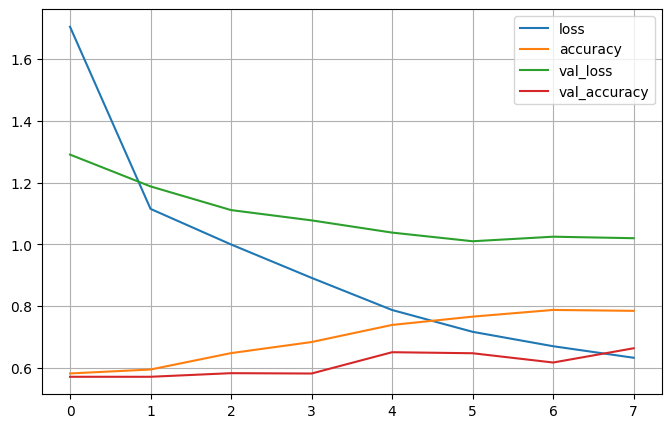

In [55]:
plot(hist)

In [56]:
model.evaluate(x_test, y_test)

56/56 [==============================] - 3s 53ms/step - loss: 0.9891 - accuracy: 0.6772


[0.9890928864479065, 0.6771653294563293]

In [57]:
y_pred = model.predict(x_test)

56/56 [==============================] - 4s 45ms/step


In [72]:
########### Problem avec sklearn, je me suis arrété ici     ############
y_pred = np.argmax(y_pred, axis=0)
y_test = np.argmax(y_test, axis=0)

#!pip3 install sklearn
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

ModuleNotFoundError: No module named 'sklearn'

In [14]:
from sklearn.metrics import f1_score
print("F1 score(macro)",f1_score(y_test, y_pred, average='macro'))
print("F1 score(micro)",f1_score(y_test, y_pred, average='micro'))

F1 score(macro) 0.6819232549545299
F1 score(micro) 0.7755823004610503


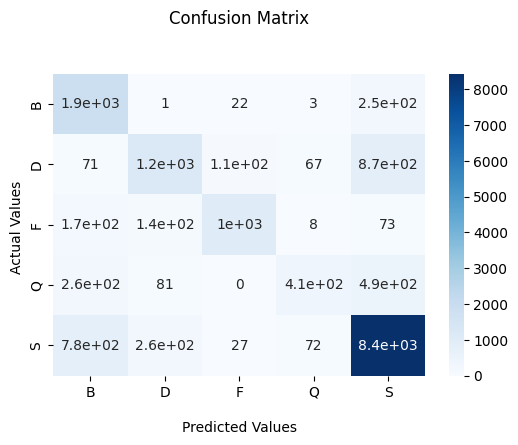

In [15]:
import seaborn as sns

ax = sns.heatmap(confusion, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

ax.xaxis.set_ticklabels(['B','D','F','Q','S'])
ax.yaxis.set_ticklabels(['B','D','F','Q','S'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [16]:
DA = np.array(['B','D','F','Q','S'])
a = ["will you go",
     "Not at all",
     "uh um"]
tokenizer = Tokenizer(num_words = 5000, split=" ")
full_data = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\dialog act RNN\\MRDA\\full_set.csv')
tokenizer.fit_on_texts(full_data['Utterances'].values)
a = tokenizer.texts_to_sequences(a)
a = np.array(a)
a = pad_sequences(a, padding='post', maxlen=100)
prediction = model.predict(np.array(a))
print(DA[prediction.argmax(1)])

['Q' 'S' 'F']


C:\Users\user1\AppData\Local\Temp/ipykernel_6732/907893161.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(a)


In [17]:
model.save('SAVED_MODEL.h5')